In [2]:
import numpy as np
import pandas as pd

from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
import joblib
from joblib import Parallel, delayed, parallel_backend
import multiprocessing
from multiprocessing import Value
from tqdm.auto import tqdm


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import shap

from helpers_scenario1 import *


In [1]:

#%%config
scenario = 1
fold = None
root_physiology_folder = "../../data/preprocessed/cleaned_and_prepro_improved/"
root_annotations_folder = "../../data/raw/"
# save_output_folder = "../../test/annotations/"
save_output_folder = "../../results/test/scenario_1/annotations/"


phys_folder_train, ann_folder_train, phys_folder_test, ann_folder_test, output_folder, = create_folder_structure(
    root_physiology_folder, root_annotations_folder, save_output_folder, scenario, fold, test=True)


zipped_dict = zip_csv_train_test_files(phys_folder_train, ann_folder_train, phys_folder_test, ann_folder_test, format = '.csv')
# print(len(zipped_dict['train']))

def process_files(annotation_file, physiology_file,):
    df_annotations = pd.read_csv(annotation_file)
    df_physiology = pd.read_csv(physiology_file)
    
    # print(physiology_file)
    X, y = preprocess(df_physiology, df_annotations,  predictions_cols=['arousal','valence'], aggregate=['mean','min'], window=[-3000, 3000], partition_window = 3)
    # print(X.shape, y.shape)
    
    save_files(X, y, annotation_file, os.path.dirname(physiology_file), os.path.dirname(annotation_file))
    
    return None

#%%
# Process the files using the context manager
# for key in zipped_dict.keys():
#     with parallel_backend('multiprocessing', n_jobs= multiprocessing.cpu_count()//2):
#         with tqdm_joblib(tqdm(total=len(zipped_dict[key]), desc=f"{key} files", leave=False)) as progress_bar:
#             results = Parallel()(
#                 (delayed(process_files)(ann_file, phys_file) for phys_file, ann_file in zipped_dict[key])
#             )



# Define models and hyperparameters
random_forest = RandomForestRegressor(
    n_estimators=50, 
    max_depth=10, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    # max_features='auto'
)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', MultiOutputRegressor(random_forest))
])

zipped_dict_npy = zip_csv_train_test_files(phys_folder_train, ann_folder_train, phys_folder_test, ann_folder_test, format = '.npy')
    
num_cpu_cores = multiprocessing.cpu_count()
def evaluate_features(i):
        # print(zipped_dict_npy['train'][i][0])
    
    # X = np.load(zipped_dict_npy['train'][i][0])
    # y = np.load(zipped_dict_npy['train'][i][1])
    
    X_train = np.load(zipped_dict_npy['train'][i][0])
    y_train = np.load(zipped_dict_npy['train'][i][1])

    
    rf_pipeline.fit(X_train, y_train)
    rf_model = rf_pipeline.named_steps['rf']
    importances = rf_pipeline.named_steps['rf'].estimators_[0].feature_importances_
    
    
    # Get the base RandomForestRegressor model
    base_rf_model = rf_model.estimator

    # Fit the base RandomForestRegressor model for each output in y_train
    for i in range(y_train.shape[1]):
        base_rf_model.fit(X_train, y_train[:, i])

    # Use TreeExplainer for the fitted base RandomForestRegressor model
    explainer = shap.TreeExplainer(base_rf_model)
    shap_values = explainer.shap_values(X_train)
    
    return importances, shap_values


all_importances = []
all_shap_values = []
with parallel_backend('multiprocessing', n_jobs=  num_cpu_cores - 5):
    with tqdm_joblib(tqdm(total=len(zipped_dict['train']), desc="Files", leave=False)) as progress_bar:
        results = Parallel()(
            (delayed(evaluate_features)(i) for i in range(len(zipped_dict['train'])))
        )
        
    # Combine results for all subjects
    for i in range(len(zipped_dict['train'])):
        all_importances.append(results[i][0])
        all_shap_values.append(results[i][1])



Files:   0%|          | 0/240 [00:00<?, ?it/s]

In [27]:
def name_columns(df):
    column_names = ['ecg_cleaned_mean_p1', 'rr_signal_mean_p1', 'bvp_cleaned_mean_p1', 'gsr_cleaned_mean_p1', 'gsr_tonic_mean_p1', 'gsr_phasic_mean_p1', 'gsr_SMNA_mean_p1', 'rsp_cleaned_mean_p1', 'resp_rate_mean_p1', 'emg_zygo_cleaned_mean_p1', 'emg_coru_cleaned_mean_p1', 'emg_trap_cleaned_mean_p1', 'skt_filtered_mean_p1',
    'ecg_cleaned_min_p1', 'rr_signal_min_p1', 'bvp_cleaned_min_p1', 'gsr_cleaned_min_p1', 'gsr_tonic_min_p1', 'gsr_phasic_min_p1', 'gsr_SMNA_min_p1', 'rsp_cleaned_min_p1', 'resp_rate_min_p1', 'emg_zygo_cleaned_min_p1', 'emg_coru_cleaned_min_p1', 'emg_trap_cleaned_min_p1', 'skt_filtered_min_p1',

    'ecg_cleaned_mean_p2', 'rr_signal_mean_p2', 'bvp_cleaned_mean_p2', 'gsr_cleaned_mean_p2', 'gsr_tonic_mean_p2', 'gsr_phasic_mean_p2', 'gsr_SMNA_mean_p2', 'rsp_cleaned_mean_p2', 'resp_rate_mean_p2', 'emg_zygo_cleaned_mean_p2', 'emg_coru_cleaned_mean_p2', 'emg_trap_cleaned_mean_p2', 'skt_filtered_mean_p2',
    'ecg_cleaned_min_p2', 'rr_signal_min_p2', 'bvp_cleaned_min_p2', 'gsr_cleaned_min_p2', 'gsr_tonic_min_p2', 'gsr_phasic_min_p2', 'gsr_SMNA_min_p2', 'rsp_cleaned_min_p2', 'resp_rate_min_p2', 'emg_zygo_cleaned_min_p2', 'emg_coru_cleaned_min_p2', 'emg_trap_cleaned_min_p2', 'skt_filtered_min_p2',

    'ecg_cleaned_mean_p3', 'rr_signal_mean_p3', 'bvp_cleaned_mean_p3', 'gsr_cleaned_mean_p3', 'gsr_tonic_mean_p3', 'gsr_phasic_mean_p3', 'gsr_SMNA_mean_p3', 'rsp_cleaned_mean_p3', 'resp_rate_mean_p3', 'emg_zygo_cleaned_mean_p3', 'emg_coru_cleaned_mean_p3', 'emg_trap_cleaned_mean_p3', 'skt_filtered_mean_p3',
    'ecg_cleaned_min_p3', 'rr_signal_min_p3', 'bvp_cleaned_min_p3', 'gsr_cleaned_min_p3', 'gsr_tonic_min_p3', 'gsr_phasic_min_p3', 'gsr_SMNA_min_p3', 'rsp_cleaned_min_p3', 'resp_rate_min_p3', 'emg_zygo_cleaned_min_p3', 'emg_coru_cleaned_min_p3', 'emg_trap_cleaned_min_p3', 'skt_filtered_min_p3']

    # Split the column names into the desired levels
    split_columns = [col.split('_') for col in column_names]

    # Organize the levels and construct a MultiIndex
    levels = [
        [col[0] for col in split_columns],
        ['_'.join(col[1:-2]) for col in split_columns],
        [col[-2] for col in split_columns],
        [col[-1] for col in split_columns],

    ]

    multiindex = pd.MultiIndex.from_arrays(levels, names=['signal', 'preprocess', 'aggregation', 'partition'])
    
    df.columns = multiindex
    return df


# df_importances = pd.DataFrame(all_importances, )
# df_shap_values = pd.DataFrame(all_shap_values)

df_importances = pd.read_csv()

df_importances = name_columns(df_importances)

# df_shap_values = name_columns(df_shap_values)

# df_importances.to_csv('feature_importances.csv')
# df_shap_values.to_csv('shap_values.csv')


display(df_importances)
# display(df_shap_values)



signal                ecg        rr           bvp       gsr            \
preprocess        cleaned    signal       cleaned   cleaned     tonic   
aggregation          mean      mean          mean      mean      mean   
partition              p1        p1            p1        p1        p1   
0            4.661693e-07  0.000114  6.127586e-07  0.000985  0.001315   
1            0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000   
2            2.670273e-06  0.001164  1.551290e-05  0.174711  0.212685   
3            8.215817e-05  0.001028  2.091793e-04  0.006813  0.021719   
4            4.990436e-06  0.000028  1.761646e-06  0.000244  0.005886   
..                    ...       ...           ...       ...       ...   
235          7.171803e-06  0.000097  9.635175e-06  0.182482  0.202132   
236          1.352124e-05  0.005751  3.566689e-05  0.028713  0.015839   
237          8.508879e-06  0.000068  2.576675e-06  0.001489  0.005512   
238          1.564784e-06  0.008323  1.269383e-02  0.000534  0.147278   
239          8.897682e-05  0.003771  2.758705e-02  0.010165  0.020631   

signal                                rsp      resp           emg  ...  \
preprocess     phasic      SMNA   cleaned      rate  zygo_cleaned  ...   
aggregation      mean      mean      mean      mean          mean  ...   
partition          p1        p1        p1        p1            p1  ...   
0            0.000079  0.000013  0.000004  0.000040  2.163636e-07  ...   
1            0.000000  0.000000  0.000000  0.000000  0.000000e+00  ...   
2            0.002340  0.000100  0.000012  0.000054  1.949002e-06  ...   
3            0.002521  0.005649  0.002933  0.002222  2.814615e-04  ...   
4            0.000031  0.000012  0.000011  0.000084  1.906224e-07  ...   
..                ...       ...       ...       ...           ...  ...   
235          0.000915  0.000042  0.000040  0.000564  3.430684e-06  ...   
236          0.001762  0.000376  0.000463  0.000095  5.422685e-04  ...   
237          0.000378  0.000022  0.000007  0.000036  1.919038e-07  ...   
238          0.000729  0.000278  0.000044  0.000704  1.314783e-06  ...   
239          0.002382  0.000789  0.236694  0.007967  6.736517e-05  ...   

signal            gsr                                     rsp      resp  \
preprocess    cleaned     tonic    phasic      SMNA   cleaned      rate   
aggregation       min       min       min       min       min       min   
partition          p3        p3        p3        p3        p3        p3   
0            0.001037  0.000548  0.000073  0.000001  0.000007  0.000067   
1            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2            0.000450  0.000522  0.000057  0.000024  0.000087  0.000112   
3            0.002030  0.000599  0.015000  0.002058  0.000070  0.001465   
4            0.000472  0.008136  0.000050  0.000017  0.000006  0.000111   
..                ...       ...       ...       ...       ...       ...   
235          0.004191  0.002454  0.000186  0.000023  0.000009  0.002624   
236          0.200432  0.160135  0.000100  0.000004  0.000342  0.000073   
237          0.003434  0.001423  0.000049  0.000003  0.000012  0.000041   
238          0.000869  0.000076  0.000028  0.000075  0.000169  0.000060   
239          0.000878  0.004510  0.005959  0.000654  0.000447  0.002441   

signal                emg                                   skt  
preprocess   zygo_cleaned  coru_cleaned  trap_cleaned  filtered  
aggregation           min           min           min       min  
partition              p3            p3            p3        p3  
0            2.814512e-07  2.862166e-07  8.937605e-07  0.002967  
1            0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
2            1.099840e-06  9.350627e-07  5.944821e-07  0.000144  
3            1.990156e-05  6.320214e-06  7.262036e-05  0.004980  
4            3.187223e-06  4.309237e-07  1.404746e-06  0.000873  
..                    ...           ...           ...       ...  
235    

Data:   Signal  Importance
0    bvp    0.000006
1    bvp    0.000000
2    bvp    0.000128
3    bvp    0.058457
4    bvp    0.000025
ANOVA Table:    Source        SS    DF        MS           F          p-unc       np2
0  Signal  0.598515     7  0.085502  145.806231  1.549735e-172  0.348029
1  Within  1.121214  1912  0.000586         NaN            NaN       NaN
Data:   Partition  Importance
0        p1    0.032062
1        p1    0.000000
2        p1    0.023983
3        p1    0.004931
4        p1    0.032600
ANOVA Table:       Source        SS   DF        MS           F         p-unc       np2
0  Partition  0.021610    2  0.010805  129.279075  1.138568e-48  0.265036
1     Within  0.059927  717  0.000084         NaN           NaN       NaN


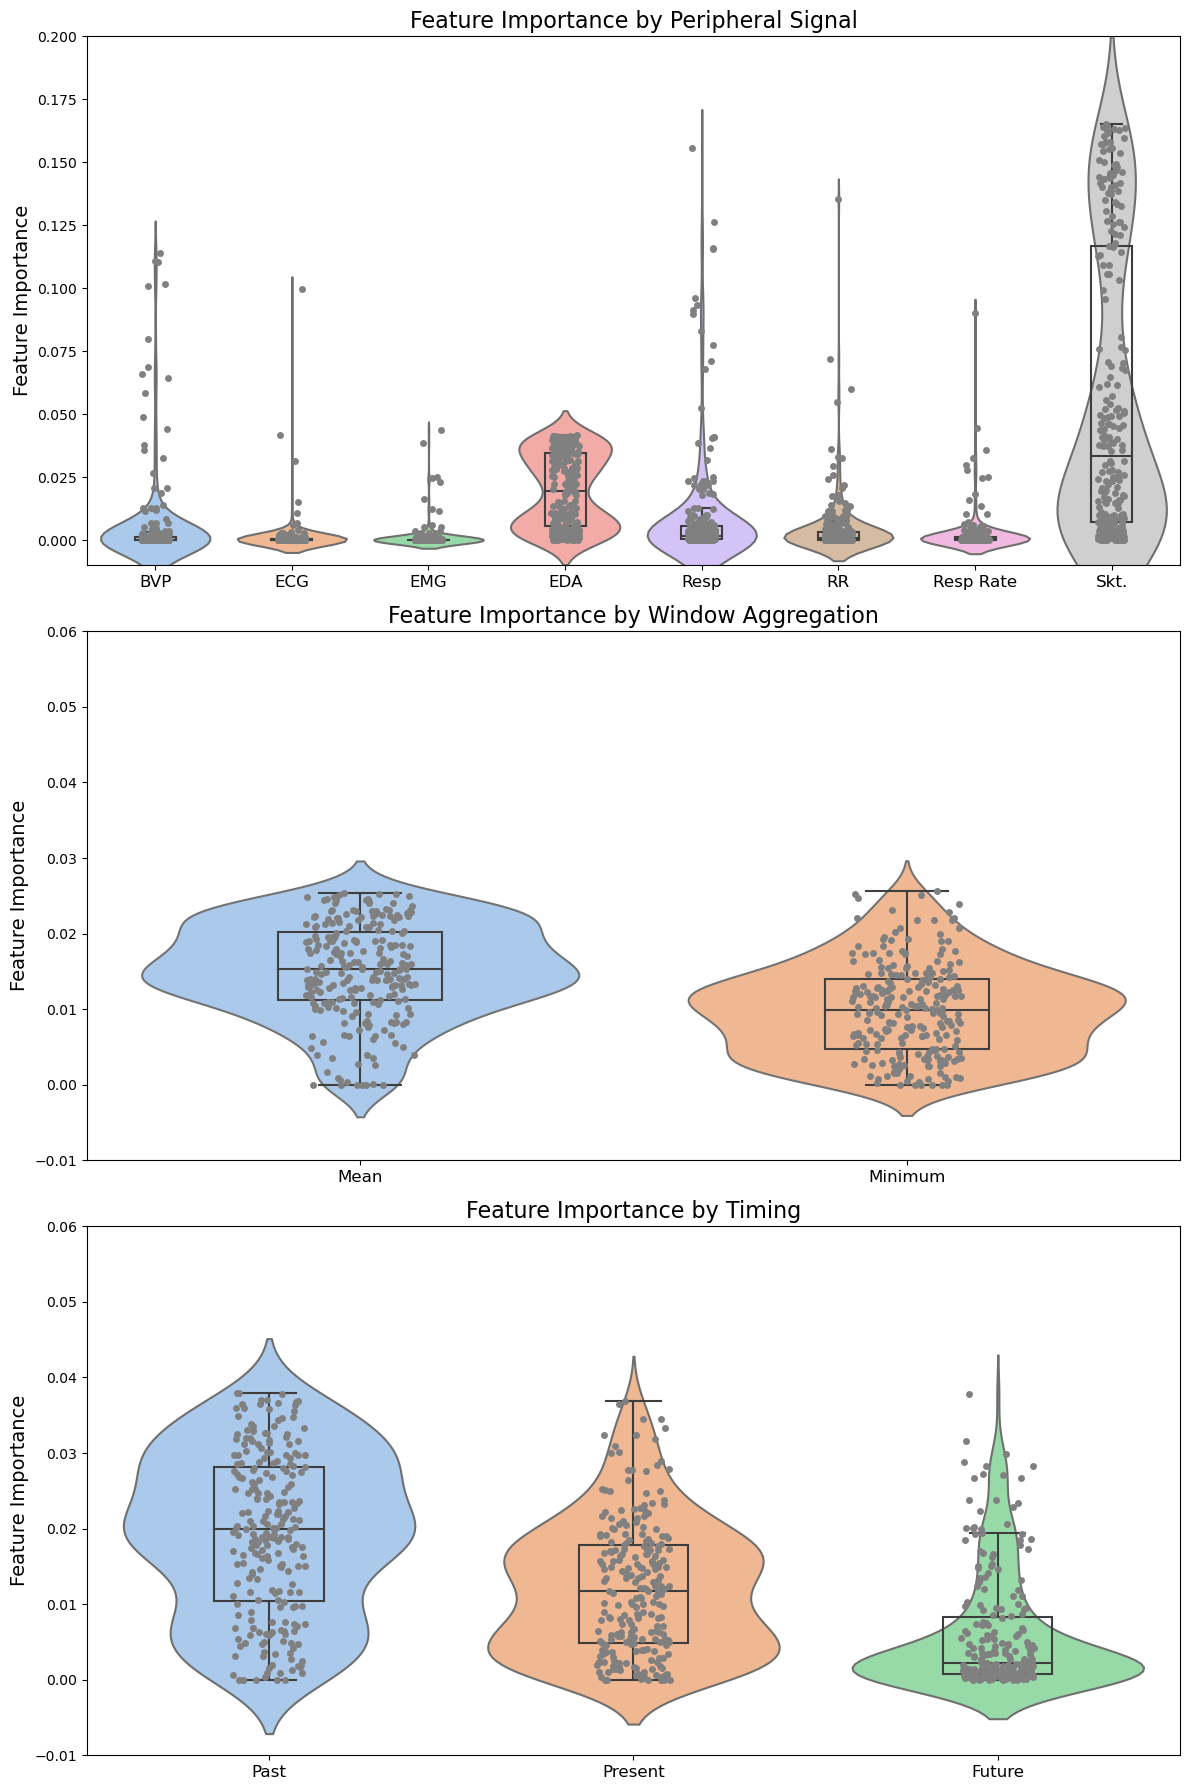

In [56]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind

# Group and aggregate the importances by the desired levels
grouped_by_signal = df_importances.groupby(level='signal', axis=1).mean()
grouped_by_aggregation = df_importances.groupby(level='aggregation', axis=1).mean()
grouped_by_partition = df_importances.groupby(level='partition', axis=1).mean()

# Melt the DataFrames for seaborn
grouped_by_signal_melt = grouped_by_signal.melt(var_name="Signal", value_name="Importance")
grouped_by_aggregation_melt = grouped_by_aggregation.melt(var_name="Aggregation", value_name="Importance")
grouped_by_partition_melt = grouped_by_partition.melt(var_name="Partition", value_name="Importance")

import pingouin as pg

def add_asterisks_anova(ax, data, labels, x_col, y_col, y_offset, alpha=0.05):
    data = data.dropna(subset=[y_col])
    print(f"Data: {data.head()}")
    anova_table = pg.anova(data=data, dv=y_col, between=x_col, detailed=True)
    print(f"ANOVA Table: {anova_table}")
    # p_value = anova_table.loc['Signal', "p-unc"]
    
    # if p_value < alpha:
    #     ax.text(len(labels) / 2, y_offset, "*", ha='center', va='bottom')

    # return p_value  # Add this line to return the p-value


def add_asterisks_ttest(ax, data, labels, x_col, y_col, y_offset, alpha=0.05):
    data = data.dropna(subset=[y_col])
    p_values = []

    for i in range(len(labels) - 1):
        group1 = data[data[x_col] == labels[i]][y_col].dropna()
        group2 = data[data[x_col] == labels[i + 1]][y_col].dropna()
        ttest_result = pg.ttest(group1, group2)
        p_value = ttest_result.at['T-test', 'p-val']
    #     p_values.append(p_value)

    #     if p_value < alpha:
    #         ax.text(i + 0.5, y_offset, "*", ha='center', va='bottom')

    # return p_values




fig, axes = plt.subplots(3, 1, figsize=(12, 18))
palette = sns.color_palette("pastel")

box_alpha = 0.7

# Set labels
signal_labels = ["BVP", "ECG", "EMG", "EDA", "Resp", "RR", "Resp Rate", "Skt."]
aggregation_labels = ["Mean", "Minimum"]
partition_labels = ["Past", "Present", "Future"]

def plot_half_violin_box_strip(data, x, y, ax):
    sns.violinplot(y=y, x=x, data=data, palette=palette, scale="width", inner=None, ax=ax)
    ylim = ax.get_ylim()

    sns.boxplot(y=y, x=x, data=data, saturation=1, showfliers=False, width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
    old_len_collections = len(ax.collections)
    sns.stripplot(y=y, x=x, data=data, color = 'gray', ax=ax)
    # for dots in ax.collections[old_len_collections:]:
    #     dots.set_offsets(dots.get_offsets() + np.array([-0.12, 0]))
    ax.set_ylim(ylim)

plot_half_violin_box_strip(grouped_by_signal_melt, "Signal", "Importance", axes[0])
axes[0].set_title("Feature Importance by Peripheral Signal", fontsize=16)
axes[0].set_xticklabels(signal_labels, fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylabel("Feature Importance", fontsize=14)
add_asterisks_anova(axes[0], grouped_by_signal_melt, signal_labels, "Signal", "Importance", 0.095)



plot_half_violin_box_strip(grouped_by_aggregation_melt, "Aggregation", "Importance", axes[1])
axes[1].set_title("Feature Importance by Window Aggregation", fontsize=16)
axes[1].set_xticklabels(aggregation_labels, fontsize=12)
axes[1].set_xlabel("")
axes[1].set_ylabel("Feature Importance", fontsize=14)
# add_asterisks_ttest(axes[1], grouped_by_aggregation_melt, aggregation_labels, "Aggregation", "Importance", 0.038)


plot_half_violin_box_strip(grouped_by_partition_melt, "Partition", "Importance", axes[2])
axes[2].set_title("Feature Importance by Timing", fontsize=16)
axes[2].set_xticklabels(partition_labels, fontsize=12)
axes[2].set_xlabel("")
axes[2].set_ylabel("Feature Importance", fontsize=14)
add_asterisks_anova(axes[2], grouped_by_partition_melt, partition_labels, "Partition", "Importance", 0.038)

# Set y-axis limits to crop extreme points
y_min, y_max = -0.01, 0.2  # Adjust these values based on the desired range
axes[0].set_ylim(-0.01, 0.2)
axes[1].set_ylim(-0.01, 0.06)
axes[2].set_ylim(-0.01, 0.06)

plt.tight_layout()
plt.show()



In [ ]:
def add_asterisks_anova(ax, data, labels, x_col, y_col, y_offset, alpha=0.05):
    groups = [data[data[x_col] == label][y_col] for label in labels]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f_stat, p_value)
    if p_value < alpha:
        ax.text(len(labels) / 2, y_offset, "*", ha='center', va='bottom')